このPython コードは、PyMC を使ってMCMCサンプリングを行います。
* 2025年8月時点では、Google Colaboratory環境では PyMC がそのまま使えますので、実行可能です。
* ローカルな計算機環境では、PyMC パッケージが含まれていないのが一般的です。
    * 例えば、Anaconda などの Distribution では、以下の例の様に、PyMC環境を用意する必要があります。
        ```
        conda create -c conda-forge -n pymc_env pymc
        conda activate pymc_env
        conda install conda-forge::ipywidgets
        conda install scikit-learn
        ```
        * これで VS codeの実行時のPython環境に、```pymc_env```を選択します。

In [ ]:
############################################
BaseDir      = 'IntroDDSJpn/Chap02/'
OutputDir    = '2PyMC-06DampedOsc/'
FileBaseName = '2PyMC-06DampedOsc'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [ ]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

Mounted at /content/drive
ipynb file path = drive/My Drive/Colab Notebooks/IntroDDS/Chap02/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
print('numpy      Ver.', np.__version__)
#
############################################
# https://docs.pymc.io/
import pymc as pm
import time
print('pymc       Ver.', pm.__version__)
#
############################################
import pickle
#
############################################
import pandas as pd
#
############################################
from scipy import stats
import scipy.optimize as opt
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.10.0
numpy      Ver. 2.0.2
pymc       Ver. 5.21.2
FilePath = drive/My Drive/Colab Notebooks/IntroDDS/Chap02/2PyMC-06DampedOsc/
 drive/My Drive/Colab Notebooks/IntroDDS/Chap02/2PyMC-06DampedOsc/ is exist.


---
最確値を書式化して文字列として返す関数
```
Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False )
```
*   返値: 書式化された文字列を返す。
*   v_mean: 平均値
*   v_std:  標準偏差
*   s_unit: 値の単位(文字列)
*   std_2digit=True: 標準偏差を2桁表示。Falseにすると1桁表示
*   latex=False: テキスト文字列として出力。Trueでは、図などでlatex表示できる文字列で出力。

In [4]:
def Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False ):
  #
  # 平均値の冪数
  # order_mean = np.floor( np.log10(v_mean) )
  order_mean = np.floor( np.log10(np.abs(v_mean)) )
  # print( 'order_mean=', order_mean )
  #
  # 標準偏差の冪数
  if std_2digits:
    # 標準偏差を有効2桁表示
    order_std  = np.floor( np.log10(v_std) - 1.0 )
  else:
    # 標準偏差を有効1桁表示
    order_std  = np.floor( np.log10(v_std) - 0.0 )
  # print( 'order_std=', order_std )
  #
  # 平均値の冪数と標準偏差の冪数の符号が同じか?
  if order_mean * order_std > 0.0:
    # 例1
    # v_mean = 4.60572E5
    # v_std  = 8.96E3
    # 例2
    # v_mean = 4.605723E-2
    # v_std  = 8.96E-5
    multi_order = order_std+1
    #
    # 共通する冪数
    multi = 10.0**multi_order
    #
    # 共通する冪数で規格化
    v_mean = v_mean / multi
    v_std  = v_std  / multi
    #
    # 共通した冪数で指数をくくって、係数は少数第1位
    if latex:
      out_str = r'(%+.1f $\pm$ %.1f)$\times10^{%+d}$ ' % (v_mean, v_std, multi_order) + s_unit
    else:
      out_str = '(%+.1f +/- %.1f)x10^(%+d) ' % (v_mean, v_std, multi_order) + s_unit
    #
  else:
    # 平均値の冪数と標準偏差の冪数の符号が異なる
    # 例2
    # v_mean = 4.605723
    # v_std  = 0.0896
    fmt_std1 = r'%%+.%df' % -order_std
    fmt_std2 = r'%%.%df'  % -order_std
    if latex:
      fmt_str = fmt_std1 + r' $\pm$ ' + fmt_std2 + ' ' + s_unit
    else:
      fmt_str = fmt_std1 + ' +/- ' + fmt_std2 + ' ' + s_unit
    #
    out_str = fmt_str % (v_mean, v_std)
  #
  return out_str

---
Yes/No

In [5]:
def YESorNO( prompt ):
  print( prompt )
  while True:
    yes_or_no = input(">> 'YES' or 'NO' [Y/N]: ").upper()
    if yes_or_no in ['Y', 'YES']:
      return True
    elif yes_or_no in ['N', 'NO']:
      return False

---
減衰振動波形回帰の例1
* 1つの減衰振動モードを含むデータのPyMCによるサンプリング。
* 参考文献のデータを利用する。
    * Ref; ["High precision modeling of a damped oscillation in coherent phonon signals by Bayesian inference" / S. Aihara, M. Hamamoto, K. Iwamitsu, M. Okada, I. Akai / AIP Adv. 7, 045107-1-5 (2017).](https://doi.org/10.1063/1.4980021)

1. 減衰振動波形関数
    $$
    g(t;\boldsymbol{\theta})
    :=
    \frac{a}{\tau_\textrm{d}-\tau_\textrm{r}}
    \left[
        \exp
        \left(
            -
            \frac{t}{\tau_\textrm{d}}
        \right)
        -
        \exp
        \left(
            -
            \frac{t}{\tau_\textrm{r}}
        \right)
    \right]
    \sin
    \left(
        2\pi{}ft+\phi
    \right)
    $$

2. 推定値と事後確率分布の標準偏差
    $$
    \begin{array}{|lc||c|c|c|}
    \hline
    &パラメータ & \hat{\theta} & \sigma_{P(\theta|\boldsymbol{D})} & \\
    \hline\hline
    積分強度 & a & 8.63 & 0.12 & \times10^{-16} \\
    \hline
    振動数 & f & 2.9300 & 0.0011 & \textrm{THz} \\
    \hline
    初期位相 & \phi & -1.0645 & 0.013 & \textrm{rad.} \\
    \hline
    立上り時定数 & \tau_\textrm{r} & 0.0813 & 0.0056 & \textrm{ps} \\
    \hline
    減衰時定数 & \tau_\textrm{d} & 2.814 & 0.060 & \textrm{ps} \\
    \hline
    \end{array}
    $$
    
    これらの内、 $ \hat{\theta}$ を真値として利用する。

In [6]:
############################################
pi2 = 2 * np.pi
############################################
def DampdOsc(t, a, f, phi, t_r, t_d):
    return a / (t_d - t_r) * (np.exp(-t/t_d) - np.exp(-t/t_r)) * np.sin( pi2 * f * t + phi )
############################################
a_true   = 8.63E-4 # ps scaled
f_true   = 2.9300  # THz
phi_true = -1.0645 # rad.
tr_true = 0.0813   # ps
td_true = 2.814    # ps

3. データの時間範囲: $t=0.0\sim8.0~\textrm{ps}$
4. データに重畳するノイズの標準偏差: $\sigma_\textrm{noise}=3.5\times10^{-5}$ 信号強度スケール

-1.0806001719124628e-21
3.5e-05


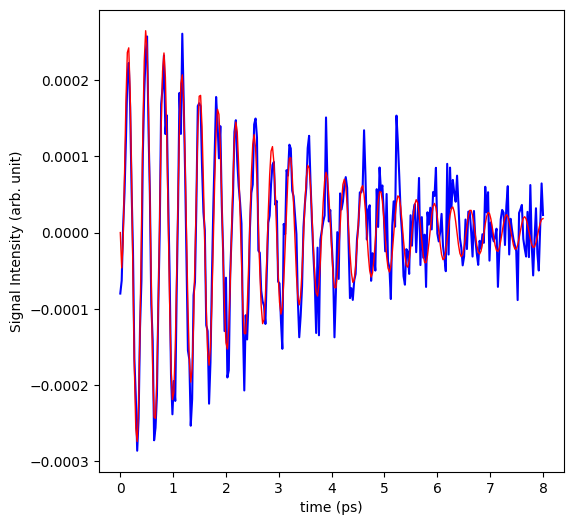

In [7]:
############################################
N = 301
#
############################################
# データの時間範囲
t = np.linspace(0, 8.0, num=N, endpoint=True )
#
############################################
# 真値データ
y_true = DampdOsc(t, a_true, f_true, phi_true, tr_true, td_true)
#
############################################
# 重畳するノイズ
sigma_noise = 3.5E-5
#
# 有限個の乱数を正規化しておく
_noise = np.random.normal( loc=0, scale=1.0, size=N )
_noise_mean = np.mean(_noise)
_noise = _noise - _noise_mean
#
y_noise = _noise / np.std(_noise) * sigma_noise
#
print( np.mean(y_noise) )
print( np.std(y_noise) )
#
############################################
# 解析対象データ
y_wn = y_true + y_noise
#
fig = plt.figure( figsize=(6,6) )
#
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('time (ps)')
ax1.set_ylabel('Signal Intensity (arb. unit)')
#
ax1.plot(t, y_wn,   color='blue', linewidth=1.5 )
ax1.plot(t, y_true, color='red', linewidth=1.0 )

データのグラフを描く関数

In [8]:
######################################
# ysets = [ [ydata, ylabel, color, width] ]
######################################
def grf_DampedOsc(x, ysets, title=None):
    #
    plt.rcParams['font.size'] = 16
    #
    fig = plt.figure( figsize=(6,6) )
    fig.subplots_adjust( \
            left=0.25, right=0.98,
            top=0.93,  bottom=0.1 )
    #
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlabel('time (ps)')
    ax1.set_ylabel('Signal intensity (arb. unit)')
    #
    for yset in ysets:
      #
      ydata  = yset[0]
      ylabel = yset[1]
      ycolor = yset[2]
      ywidth = yset[3]
      #
      ax1.plot(x, ydata, label=ylabel, color=ycolor, linewidth=ywidth )
    #
    (x_left, x_right) = ax1.set_xlim()
    (y_bot, y_top) = ax1.set_ylim()
    #
    if title is not None:
      plt.title( title )

    plt.legend()
    #
    plt.show()
    #
    return fig

---
真値、解析対象データのグラフを描画

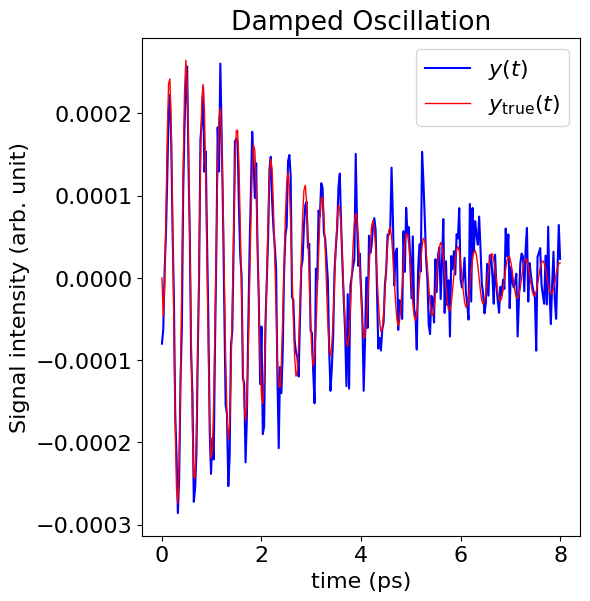

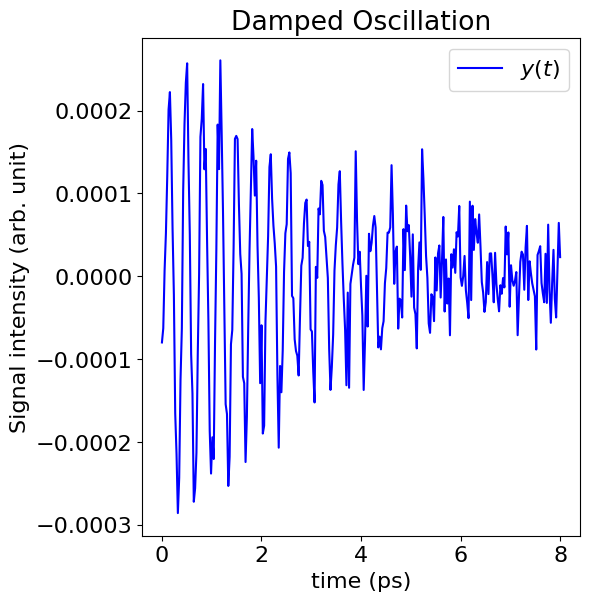

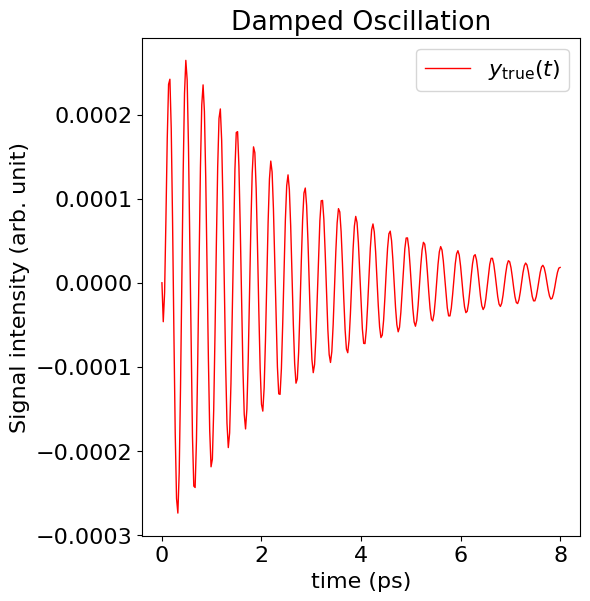

In [9]:
######################################
grf_title = 'Damped Oscillation'
######################################
ysets = [ [y_wn,   r'$y(t)$',            'blue', 1.5 ],
          [y_true, r'$y_{\rm true}(t)$', 'red',  1.0 ] ]
#
fig = grf_DampedOsc( t, ysets, title=grf_title )
pdfName = FilePath + FileBaseName + '-data1.pdf'
fig.savefig( pdfName )
#
######################################
ysets = [ [y_wn,   r'$y(t)$',            'blue', 1.5 ] ]
#
fig = grf_DampedOsc( t, ysets, title=grf_title )
pdfName = FilePath + FileBaseName + '-data2.pdf'
fig.savefig( pdfName )
#
######################################
ysets = [ [y_true, r'$y_{\rm true}(t)$', 'red',  1.0 ] ]
#
fig = grf_DampedOsc( t, ysets, title=grf_title )
pdfName = FilePath + FileBaseName + '-data3.pdf'
fig.savefig( pdfName )

---
事前確率に用いる確率分布
1. 正規分布
$$
{\rm PNormal}(x;\mu,\sigma)=\frac{1}{\sigma\sqrt{2\pi}}
\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right],
\;\;\;
x\in[-\infty,\infty]
$$

2. 一様分布
$$
{\rm PUniform}(x;lower,upper)=
\left\{
  \begin{array}{cc}
    \displaystyle
    \frac{1}{upper - lower},
    &
    x\in[lower,upper]
    \\
    0,
    &
    x\not\in[lower,upper]
  \end{array}
\right.
$$

3. ガンマ分布
$$
{\rm PGamma}(x;\alpha,\beta)=
\frac{\beta^\alpha{}x^{\alpha-1}}{\Gamma(\alpha)}\exp(-\beta{}x),
\;\;\;
x\in[0,\infty]
$$

4. von Mises分布
$$
{\rm PVonMises}(x;\mu,\kappa)
=
\frac{
  \exp
  \left[
    \kappa
    \cos(x-\mu)
  \right]
}{
  2\pi
  I_{0}(\kappa)
}
,
$$

In [10]:
############################################
from math import gamma as gamma_func
############################################
sqrt2pi = np.sqrt( 2 * np.pi )
############################################
# ##1. 正規分布
def PNormal(x, mu, sigma):
  return np.exp( - (x - mu)**2 ) / (sigma * sqrt2pi )
############################################
# ##2. 一様分布
def PUniform(x, lower, upper):
  # res = 1.0 / (upper-lower)
  # res[ (x<lower) ] = 0
  # res[ (x>upper) ] = 0
  #return res
  return (1-np.maximum( np.sign( (x-lower)*(x-upper) ), 0 ))/(upper-lower)
############################################
# ##3. ガンマ分布
def PGamma(x, alpha, beta):
    res = beta**alpha * x**(alpha-1) * np.exp(-beta*x)/ gamma_func(alpha)
    res[(x<0)] = 0
    return res
############################################
# フォン・ミーゼス(von Mises)分布
from scipy.special import iv
#
pi2 = 2 * np.pi
#
def PVonMises(x, mu, kappa):
  I0kappa2pi = pi2 * iv( 0, kappa )
  return np.exp( kappa * np.cos(x - mu) ) / I0kappa2pi

確率分布を描く関数

In [11]:
############################################
def grf_Prob( ProbSets, x_label, title, xticks_rotate=False):
    #
    plt.rcParams['font.size'] = 16
    #
    fig = plt.figure( figsize=(6,6) )
    #
    figadj_bottom = 0.1
    #
    if xticks_rotate:
      figadj_bottom = 0.25
    #
    fig.subplots_adjust( \
            left=0.25, right=0.98,
            top=0.93,  bottom=figadj_bottom )
    #
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlabel( x_label )
    #
    if xticks_rotate:
      plt.xticks(rotation=90)
    #
    ax1.set_ylabel('Probability distribution')
    #
    for ProbSet in ProbSets:
      #
      plot_type  = ProbSet[0]
      plot_x     = ProbSet[1]
      plot_y     = ProbSet[2]
      plot_label = ProbSet[3]
      plot_color = ProbSet[4]
      #
      # plot_type == 0; plot
      if plot_type == 0:
        ax1.plot(plot_x, plot_y, color=plot_color, linewidth=2.0, label=plot_label )
      #
    #
    (x_left, x_right) = ax1.set_xlim()
    (y_bot, y_top) = ax1.set_ylim()
    (y_bot, y_top) = ax1.set_ylim(0, y_top*1.2)
    #
    for ProbSet in ProbSets:
      #
      plot_type  = ProbSet[0]
      plot_x     = ProbSet[1]
      plot_y     = ProbSet[2]
      plot_label = ProbSet[3]
      plot_color = ProbSet[4]
      #
      # plot_type == 1; vline
      if plot_type == 1:
        ax1.vlines(plot_x, y_bot, y_top, label=plot_label, color=plot_color, linestyles='dashed', linewidth=1.0)
    #
    plt.title( title )
    plt.legend()
    #
    plt.show()
    #
    return fig

---
積分強度$a$の事前確率
$$
P(a)={\rm PGamma}(x;\alpha=10.0,\beta=10430.0)
$$
* $a_{\rm true} = 8.63\times10^{-4}$
* Mode値: $(\alpha-1)/\beta=8.63\times10^{-4}$

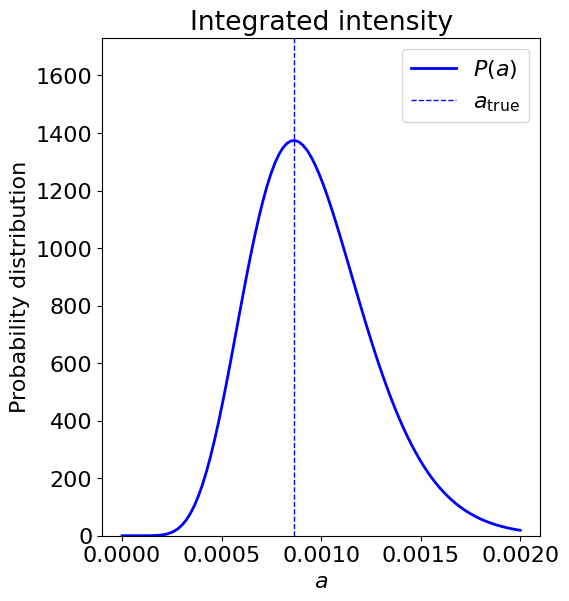

In [12]:
############################################
# 事前確率を描く横軸のポイント数
prob_points = 100
############################################
# a_true   = 8.63E-4 # ps scaled
a_alpha = 10.0
a_beta  = 10430.0
#
a_x = np.linspace(0, 20.0E-4, num=prob_points, endpoint=True )
a_y = PGamma(a_x, a_alpha, a_beta)
#
############################################
a_ProbSet = [ 0, a_x,    a_y,  r'$P(a)$',        'blue' ]
a_trueSet = [ 1, a_true, None, r'$a_{\rm true}$','blue' ]
#
ProbSets = [ a_ProbSet, a_trueSet ]
fig = grf_Prob( ProbSets, r'$a$', 'Integrated intensity')
pdfName = FilePath + FileBaseName + '-Prior-a.pdf'
fig.savefig( pdfName )

振動数$f$の事前確率
$$
P(f)={\rm PGamma}(x;\alpha=10.0,\beta=3.07)
$$
* $f_{\rm true} = 2.9300~\textrm{THz}$
* Mode値: $(\alpha-1)/\beta=2.932~\textrm{THz}$

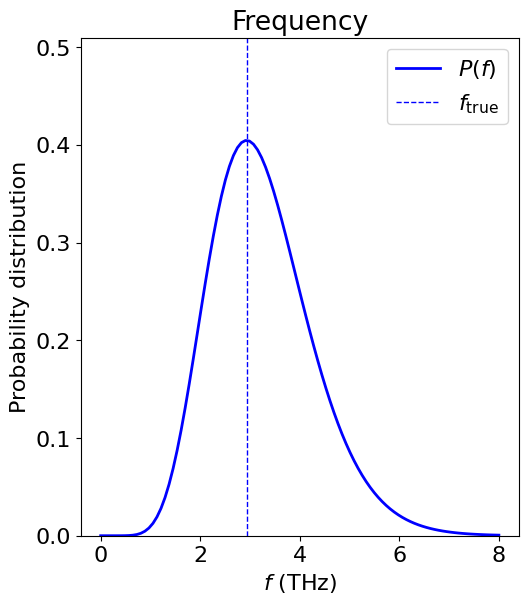

In [13]:
############################################
# f_true   = 2.9300  # THz
f_alpha = 10.0
f_beta  = 3.07
#
f_x = np.linspace(0, 8.0, num=prob_points, endpoint=True )
f_y = PGamma(f_x, f_alpha, f_beta)
#
############################################
f_ProbSet = [ 0, f_x,    f_y,  r'$P(f)$',        'blue' ]
f_trueSet = [ 1, f_true, None, r'$f_{\rm true}$','blue' ]
#
ProbSets = [ f_ProbSet, f_trueSet ]
fig = grf_Prob( ProbSets, r'$f$ (THz)', 'Frequency')
pdfName = FilePath + FileBaseName + '-Prior-f.pdf'
fig.savefig( pdfName )

初期位相$\phi$の事前確率
$$
P(\phi)=
{\rm PVonMises}(x;0.0,0.01)
$$
* $\phi_{\rm true} = -1.0645~\textrm{rad.}$

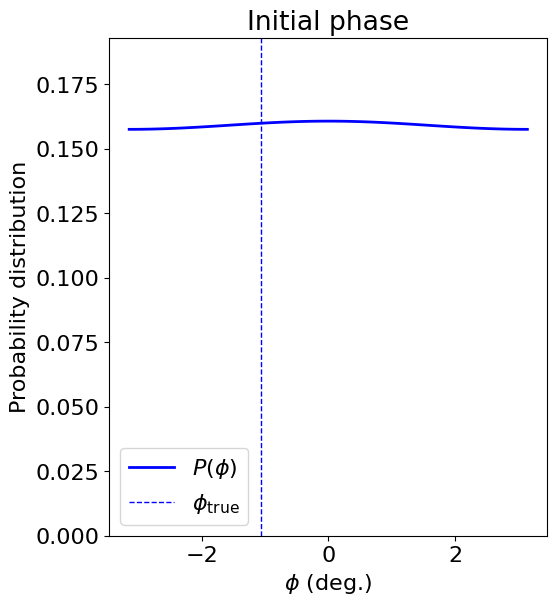

In [14]:
############################################
phi_mu    = 0.0
phi_kappa = 0.01
phi_x = np.linspace(-np.pi, +np.pi, num=prob_points, endpoint=True )
phi_y = PVonMises(phi_x, phi_mu, phi_kappa)
#
############################################
phi_ProbSet = [ 0, phi_x,    phi_y,  r'$P(\phi)$',        'blue' ]
phi_trueSet = [ 1, phi_true, None,   r'$\phi_{\rm true}$','blue' ]
#
ProbSets = [ phi_ProbSet, phi_trueSet ]
fig = grf_Prob( ProbSets, r'$\phi$ (deg.)', 'Initial phase')
pdfName = FilePath + FileBaseName + '-Prior-phi.pdf'
fig.savefig( pdfName )

立上り時定数$\tau_\textrm{r}$の事前確率
$$
P(\tau_\textrm{r})={\rm PGamma}(x;\alpha=10.0,\beta=110.7)
$$
* $\tau_\textrm{r-true} = 0.0813~\textrm{ps}$
* Mode値: $(\alpha-1)/\beta=0.08130~\textrm{ps}$

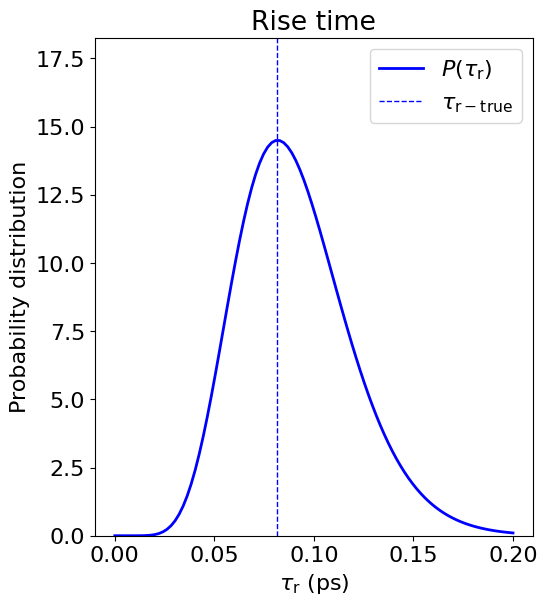

In [15]:
############################################
# tr_true = 0.0813  # ps
tr_alpha = 10.0
tr_beta  = 110.07
#
tr_x = np.linspace(0, 0.2, num=prob_points, endpoint=True )
tr_y = PGamma(tr_x, tr_alpha, tr_beta)
#
############################################
tr_ProbSet = [ 0, tr_x,    tr_y, r'$P(\tau_{\rm r})$',  'blue' ]
tr_trueSet = [ 1, tr_true, None, r'$\tau_{\rm r-true}$','blue' ]
#
ProbSets = [ tr_ProbSet, tr_trueSet ]
fig = grf_Prob( ProbSets, r'$\tau_{\rm r}$ (ps)', 'Rise time')
pdfName = FilePath + FileBaseName + '-Prior-tr.pdf'
fig.savefig( pdfName )

減衰時定数$\tau_\textrm{d}$の事前確率
$$
P(\tau_\textrm{d})={\rm PGamma}(x;\alpha=10.0,\beta=3.20)
$$
* $\tau_\textrm{d-true} = 2.814~\textrm{ps}$
* Mode値: $(\alpha-1)/\beta=2.813~\textrm{ps}$

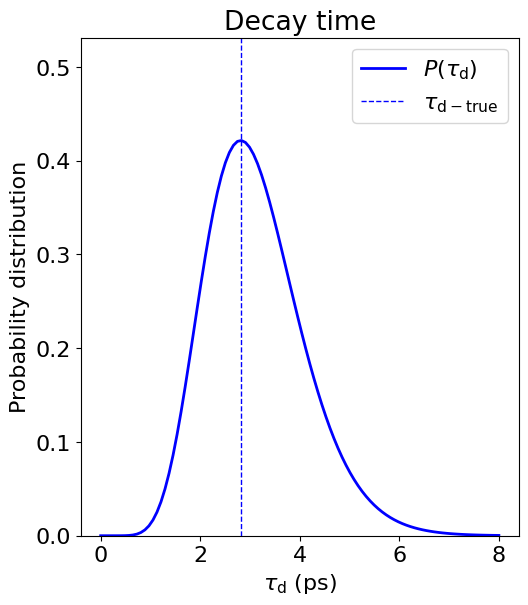

In [16]:
############################################
# td_true = 2.814   # ps
td_alpha = 10.0
td_beta  = 3.20
#
td_x = np.linspace(0, 8.0, num=prob_points, endpoint=True )
td_y = PGamma(td_x, td_alpha, td_beta)
#
############################################
td_ProbSet = [ 0, td_x,    td_y, r'$P(\tau_{\rm d})$',  'blue' ]
td_trueSet = [ 1, td_true, None, r'$\tau_{\rm d-true}$','blue' ]
#
ProbSets = [ td_ProbSet, td_trueSet ]
fig = grf_Prob( ProbSets, r'$\tau_{\rm d}$ (ps)', 'Decay time')
pdfName = FilePath + FileBaseName + '-Prior-td.pdf'
fig.savefig( pdfName )

RMSDの事前確率
$$
P(\textrm{RMSD})=
{\rm PUniform}(x;0,\sigma_{\boldsymbol{y}})
$$

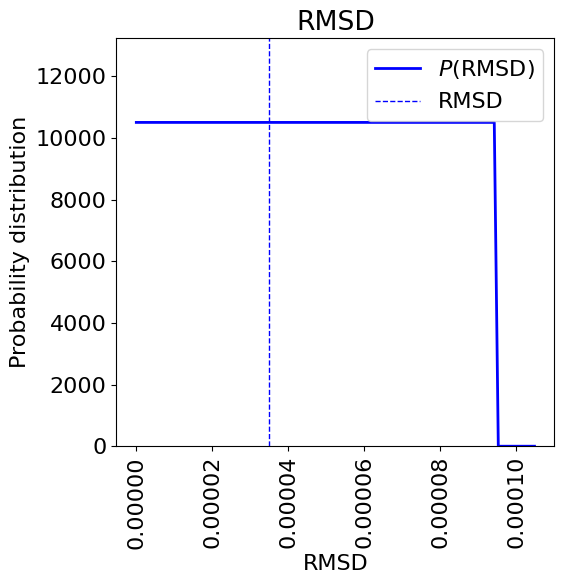

In [17]:
############################################
# RMSD
RMSD_lower = 0.0
RMSD_upper = np.std(y_wn)
#
RMSD_x = np.linspace(0, 1.1*RMSD_upper, num=prob_points, endpoint=True )
RMSD_y = PUniform(RMSD_x, RMSD_lower, RMSD_upper)
#
############################################
RMSD_ProbSet = [ 0, RMSD_x,    RMSD_y,     r'$P({\rm RMSD})$', 'blue' ]
RMSD_trueSet = [ 1, np.std(y_noise), None, r'RMSD',            'blue' ]
#
ProbSets = [ RMSD_ProbSet, RMSD_trueSet ]
fig = grf_Prob( ProbSets, r'RMSD', 'RMSD', xticks_rotate=True)
pdfName = FilePath + FileBaseName + '-Prior-RMSD.pdf'
fig.savefig( pdfName )
# print(RMSD_upper)

---
サンプリング結果をpickles ファイルとして保存する。

https://docs.python.org/ja/3/library/pickle.html

* MCMCサンプリングは時間がかかるので、後処理の解析をやり直す場合、このpickleファイルを読み込んで行う。

In [18]:
############################################
def SaveTrace( file_fpath, trace ):
    print( 'Saving pickle file = %s' % file_fpath )
    with open( file_fpath, mode='wb') as f:
        pickle.dump(trace, f)
#
############################################
def LoadTrace( file_fpath):
  return pickle.load( open( file_fpath, mode='rb') )

---
サンプリング条件

In [19]:
############################################
steps_sampling_ = 100000
steps_tuning_   = 20000
chains_         = 4
dtau_max_       = int(steps_sampling_ / 10)

---
1. $\theta_{t}$ ($t=1,2,\cdots,T$)の履歴でラグ$\Delta\tau$だけずらした要素を準備し、それぞれで平均値を求める。
$$
\langle\theta\rangle_{0}
=
\left\langle
\sum_{\tau=1}^{T-\Delta\tau}
\theta_{\tau}
\right\rangle
$$
$$
\langle\theta\rangle_{\Delta\tau}
=
\left\langle
  \sum_{\tau^\prime=1+\Delta\tau}^{T}
  \theta_{\tau^\prime}
\right\rangle
$$

2. 平均値と各履歴の差を求め、各履歴同士の積を計算し、その平均値を、$\Delta\tau$の共分散として求める。
$$
{\rm Cov}(\Delta\tau)
:=
\frac{
  \displaystyle
  \left\langle
  \sum_{\tau=1}^{T-\Delta\tau}
  \left[
    \theta_{\tau}
    -
    \langle\theta\rangle_{0}
  \right]
  \left[
    \theta_{\tau+\Delta\tau}
    -
    \langle\theta\rangle_{\Delta\tau}
  \right]
  \right\rangle
}{\sigma^{2}}
,
$$

ここで$\sigma^{2}$は次式で定義される$\theta_{\tau}$の分散である。
$$
\sigma^{2}
:=
\left\langle
  \sum_{\tau=1}^{T}
    \left[
      \theta_{\tau}
      -
      \langle\theta\rangle
    \right]^{2}
\right\rangle
,
\;\;\;\;
\langle\theta\rangle
=
\left\langle
  \sum_{\tau=1}^{T}
      \theta_{\tau}
\right\rangle
$$

In [20]:
############################################
def hist_cov( trace_, dtau ):
  if dtau == 0:
    # Δτ だけずらした要素を準備
    trace_0 = trace_
    trace_1 = trace_
  else:
    # Δτ だけずらした要素を準備
    trace_0 = trace_[dtau:]
    trace_1 = trace_[:-dtau]
  #
  # それぞれで平均値を求める
  mean_0 = np.mean( trace_0 )
  mean_1 = np.mean( trace_1 )
  #
  # 平均値と各履歴の差
  diff_0 = trace_0 - mean_0
  diff_1 = trace_1 - mean_1
  #
  # 各履歴同士の積を計算し、その平均値を求める
  return( np.mean( diff_0 * diff_1 ) )

${\rm Cov}(\Delta\tau)$の時間特性において、$\Delta\tau\approx0$の高速減衰の後に、相関の緩和が現れる [J. Phys. Soc. Jpn. **65**, 1604 (1996)](https://journals.jps.jp/doi/pdf/10.1143/JPSJ.65.1604)。そのためFast成分とSlow成分を含んだ次式で回帰し、相関MCS $\mathcal{T}_\textrm{Slow}$を推定する。 ${\rm Cov}(\Delta\tau)$は、${\rm Cov}(0)=1$と規格化されているので、回帰式は以下の通り。
$$
{\rm Cov}(\Delta\tau)
\approx
(1-C_\textrm{Slow})
\exp
\left(
  -
  \frac{\Delta\tau}{\mathcal{T}_\textrm{Fast}}
\right)
+
C_\textrm{Slow}
\exp
\left(
  -
  \frac{\Delta\tau}{\mathcal{T}_\textrm{Slow}}
\right)
$$

In [21]:
############################################
def Cov_ExpDamp(x, T0, C, T):
  return (1-C) * np.exp( - x / T0 ) + C * np.exp( - x / T )
#
############################################
def Cov_ExpDampComps(x, T0, C, T):
  y0 = (1-C)*np.exp( - x / T0 )
  y1 = C * np.exp( - x / T )
  #
  return y0, y1, y0+y1

scipy.optimize.least squares()
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
```
result = scipy.optimize.least_squares( residual, theta0, bounds=(-inf, inf), method='trf' )
```
* residual: 残差を計算する関数
* theta0: 探索初期値
* bounds: 探索範囲の指定
* method:
  * 'trf' : Trust Region Reflective algorithm
  * 'dogbox' : Dogleg algorithm with rectangular trust regions
  * 'lm' : Levenberg-Marquardt algorithm

残差関数:
$${\rm{}Residual}(\boldsymbol{\theta};\boldsymbol{x}, \boldsymbol{y})=\boldsymbol{y}-g(\boldsymbol{x};\boldsymbol{\theta})$$

* 探索初期値: $\boldsymbol{\theta}_{0}=\{C_{0},\mathcal{T}_{0}\}$
* least_squares()を用いた解の探索

In [22]:
############################################
# 残差関数
def Cov_residual(theta, x, y):
  T0, C, T = theta[0], theta[1], theta[2]
  return y - Cov_ExpDamp(x, T0, C, T)

${\rm Cov}(\Delta\tau)$のグラフを描く

In [23]:
############################################
# y_fits = [ [ y_fit, y_label, linestyle, color ], ]
############################################
def GrfCov( x_data, y_cov, y_fits, grf_title, x_magni=None, y_log=False ):
  #
  plt.rcParams['font.size'] = 24
  #
  fig = plt.figure( figsize=(9,8) )
  #
  fig.subplots_adjust(left=0.15, right=0.93, top=0.95, bottom=0.12)
  #
  ax1 = fig.add_subplot(1,1,1)
  ax1.set_xlabel( r'$\Delta\tau$ (MCSs)' )
  #
  if y_log:
    ax1.set_ylabel( r'${\rm Cov}(\Delta\tau) / log scale$' )
    ax1.set_ylim(2.0E-3, 2.0)
    ax1.set_yscale('log')
  else:
    ax1.set_ylabel( r'${\rm Cov}(\Delta\tau)$' )
    ax1.set_ylim(-0.15, 1.15)
  #
  ax1.scatter( x_data, y_cov, color='black',
               label=r'${\rm Cov}(\Delta\tau)$', s=20 )
  #
  for y_fit in y_fits:
    #
    y_fit_data      = y_fit[ 0 ]
    y_fit_label     = y_fit[ 1 ]
    y_fit_linestyle = y_fit[ 2 ]
    y_fit_color     = y_fit[ 3 ]
    #
    ax1.plot( x_data, y_fit_data, color=y_fit_color, linestyle=y_fit_linestyle,
              linewidth=2, label=y_fit_label )
  #
  (x_left_, x_right_) = ax1.set_xlim()
  #
  if x_magni is not None:
    ax1.set_xlim(x_left_ / x_magni, x_right_ / x_magni )
  #
  ax1.legend( fontsize=16 )
  #
  plt.title( grf_title )
  plt.show()
  #
  return fig

各 chain において、各 key に対して、
1. $\Delta\tau=0\sim200~{\rm MCSs}$の範囲で ${\rm Cov}(\Delta\tau)$を計算。
2. その結果を、次式で最小二乗法により解析して、緩和時間$\mathcal{T}_\textrm{Slow}$を推定。
$$
{\rm Cov}(\Delta\tau)
\approx
(1-C_\textrm{Slow})
\exp
\left(
  -
  \frac{\Delta\tau}{\mathcal{T}_\textrm{Fast}}
\right)
+
C_\textrm{Slow}
\exp
\left(
  -
  \frac{\Delta\tau}{\mathcal{T}_\textrm{Slow}}
\right)
$$

* 探索初期値は、$\mathcal{T}_\textrm{Fast}^{0}=1.0~\textrm{MCSs}$、$C_\textrm{Slow}^{0}=0.1$、$\mathcal{T}_\textrm{Slow}^{0}=5.0~\textrm{MCSs}$とする。
* パラメータは全て正値とし、$\mathcal{T}_\textrm{Fast}$, $\mathcal{T}_\textrm{Slow}$の上限値は解析対処範囲MCSsの2倍、$C_\textrm{Slow}$の上限は1とする。

3. それの結果をグラフ出力

In [24]:
############################################
# def CovDecayMCSs( trace_, dtau_max=200, T0init=1.0, Cinit=0.1, Tinit=5.0 ):
def CovDecayMCSs( trace_, dtau_max=dtau_max_, T0init=1.0, Cinit=0.1, Tinit=5.0 ):
  #
  msg_ = '***** Estimating Cov Decay MCSs *****'
  print( msg_ )
  #
  # T_opt_longest_chains = np.infty
  T_opt_longest_chains = np.inf
  T_opt_longest_chain_number = -1
  msgs = []
  msgs.append( msg_ )
  #
  for chain_ in trace_.posterior.chain:
    # 各 chain に対して
    chain_ = int(chain_)
    #
    # 各 key に対して
    T_opt_longest = 0.0
    Key_T_opt_longest = ""
    #
    for key_ in trace_.posterior.keys():
      #
      # traceから chain, keyのデータを切り出す
      theta_trace = np.array( trace_.posterior[ key_ ][ chain_ ] )
      #
      N_iters = theta_trace.size
      #
      ############################################
      # Cov(Δτ)の計算
      x_dtau = []
      y_cov  = []
      #
      cov0 = hist_cov( theta_trace, 0 )
      #
      for dtau in range(dtau_max):
        x_dtau.append( dtau  )
        y_cov.append( hist_cov( theta_trace, dtau )/cov0 )
        #
      x_dtau = np.array( x_dtau )
      y_cov  = np.array( y_cov )
      #
      ############################################
      # 最小二乗法で　C * exp( -Δτ/T )として解析
      x_data = x_dtau
      x_data_max = np.amax(x_data)
      y_data = y_cov
      #
      ######################
      # 探索初期値
      theta0 = np.array( [ T0init, Cinit, Tinit ] )
      #
      ######################
      # result = opt.least_squares( residual, theta0, method='trf',args=(x_data,y_data), bounds=(0,+np.inf) )
      # result = opt.least_squares( Cov_residual, theta0, method='lm',args=(x_data,y_data) )
      # result = opt.least_squares( Cov_residualV2, theta0, method='lm',args=(x_data,y_data) )
      result = opt.least_squares( Cov_residual, theta0, bounds =[ [0,0,0],[2*x_data_max, 1.0, 2*x_data_max] ], args=(x_data,y_data) )
      T0_opt, C_opt, T_opt = result.x[0], result.x[1], result.x[2]
      #
      # T0_opt と T_opt の長短関係がひっくり返っていないか?
      if T0_opt > T_opt:
        T0_opt, T_opt = T_opt, T0_opt
        C_opt = 1.0 - C_opt
      #
      msg_ = '  chain = %d, N_iters = %d, key = %-8s, Fast(C=%.4f,T=%.3f MCSs), Slow(C=%.4f,T=%.3f MCSs)' % (chain_, N_iters, key_, (1-C_opt), T0_opt, C_opt, T_opt )
      msgs.append( msg_ )
      #
      if T_opt > T_opt_longest:
        T_opt_longest = T_opt
        Key_T_opt_longest = msg_
      #
      print(  msg_ )
      #
      # fit_ExpDamp = Cov_ExpDampV2( x_dtau, T0_opt, C_opt, T_opt)
      fit_ExpDampY0, fit_ExpDampY1, fit_ExpDamp = Cov_ExpDampComps( x_dtau, T0_opt, C_opt, T_opt)
      #
      fits_ExpDamp = [
          [ fit_ExpDampY0, r'Fast: $C=$%.4f, $\mathcal{T}=%.3f~{\rm MCSs}$' % ((1-C_opt),T0_opt ), 'dashed', 'lime' ],
          [ fit_ExpDampY1, r'Slow: $C=$%.4f, $\mathcal{T}=%.3f~{\rm MCSs}$' % (C_opt,T_opt ),      'dashed', 'blue' ],
          [ fit_ExpDamp,   r'Fast + Slow',                                                         'solid',  'red'  ]
      ]
      #
      ############################################
      Grftitle = key_ + " (chain=%d)" % chain_
      ####
      fig = GrfCov( x_dtau, y_cov, fits_ExpDamp, Grftitle )
      #
      pdfSubName = '%s%02d' % (key_, chain_)
      pdfName = FilePath + FileBaseName + '-' + samplerName + '-Cov-' + pdfSubName + '-A.pdf'
      print( pdfName )
      fig.savefig( pdfName )
      ####
      fig = GrfCov( x_dtau, y_cov, fits_ExpDamp, Grftitle, x_magni=50 )
      #
      pdfSubName = '%s%02d' % (key_, chain_)
      pdfName = FilePath + FileBaseName + '-' + samplerName + '-Cov-' + pdfSubName + '-B.pdf'
      print( pdfName )
      fig.savefig( pdfName )
      ####
      fig = GrfCov( x_dtau, y_cov, fits_ExpDamp, Grftitle, y_log=True )
      #
      pdfSubName = '%s%02d' % (key_, chain_)
      pdfName = FilePath + FileBaseName + '-' + samplerName + '-Cov-' + pdfSubName + '-Alog.pdf'
      print( pdfName )
      fig.savefig( pdfName )
      ####
      fig = GrfCov( x_dtau, y_cov, fits_ExpDamp, Grftitle, x_magni=50, y_log=True  )
      #
      pdfSubName = '%s%02d' % (key_, chain_)
      pdfName = FilePath + FileBaseName + '-' + samplerName + '-Cov-' + pdfSubName + '-Blog.pdf'
      print( pdfName )
      fig.savefig( pdfName )
      #
      #
    #
    msg_ = 'The longest: ' + Key_T_opt_longest
    msgs.append( msg_ )
    #
    print( msg_ )
    #
    if T_opt_longest < T_opt_longest_chains:
      T_opt_longest_chains = T_opt_longest
      T_opt_longest_chain_number = chain_
    #
  #
  msg_ = '***** Chain=%d has the shortest Cov Decy MCSs. *****' % T_opt_longest_chain_number
  msgs.append( msg_ )
  print( msg_ )
  #
  for msg_ in msgs:
    print( msg_ )
  #
  return T_opt_longest_chain_number

---
各chainのチェックと統計量

* 各chainのサンプルトレースで、以下を調べる。
    1. HMCの発散個数
    2. 発散データを除いたトレースでの平均値と標準偏差
    3. 発散データを除いたトレースでのRMSD最小値とそのindex

In [25]:
############################################
# 各chainのチェックと統計量を計算する関数
def MCMC_stats1( trace, rmsd='rmsd' ):
  #
  chains = len( trace.sample_stats.chain )
  #
  # # diverging
  # diverging = []
  #
  # DataFrame
  dfs = []
  #
  # MLE
  MLE_rmsd = []
  MLE_idx  = []
  #
  # # Counting diverging & making dataframes
  # making dataframes
  for ch in range(chains): # trace1.sample_stats.chain:
    #
    # diverging.append( len( trace.sample_stats.diverging[ch][trace.sample_stats.diverging[ch]==True] ) )
    #
    dfs.append( trace.sel(chain=[ch]).posterior.to_dataframe() )
  #
  # Reporting
  for ch in range(chains): # trace1.sample_stats.chain:
    print( '--------------' )
    print( 'Chain  = %d / %d' % (ch, chains) )
    # print( ' diverging = %d samples' % diverging[ch] )
    #
    df = dfs[ ch ]
    #
    # rows_to_drop = df.index[ trace.sample_stats.diverging[ch]==True ]
    # df = df.drop(rows_to_drop)
    # dfs[ ch ] = df
    #
    for idx in df.columns:
      #
      data = np.array( df[idx] )
      data_len = len( data )
      data_mean = np.mean( data )
      data_std  = np.std( data )
      #
      str_print = ' %-6s (%5d) = ' % ( idx, data_len )
      print( str_print +  Format_MostProbableValue( data_mean, data_std, '' ) )
      #
      # The end of / for idx in df.columns:
    #
    data = np.array( df[rmsd] )
    MLE_idx_  = np.argmin( df[rmsd] )
    MLE_rmsd_ = data[MLE_idx_]
    MLE_idx.append( MLE_idx_ )
    MLE_rmsd.append( MLE_rmsd_ )
    print( ' MLE-%s (%5d) = %.4E' % (rmsd, MLE_idx_, MLE_rmsd_ ) )
    # The end of / for ch in range(chains)
  return dfs, MLE_idx, MLE_rmsd

この例では、複数のchainの内1つを選ぶ。(どのchainも正しくサンプリングされているなら、複数のchainを統合しても良い。)

1. 各chainのチェックと統計量を計算
2. 各chainで相関の緩和時間が一番短いchainを選択する。
3. 各パラメータでサンプリングされた値における事前確率を計算
4. $\sigma_\textrm{noise}$を用いて尤度を計算
5. 尤度と事前確率をかけて事後確率を計算
6. 統計量のまとめのデータフレームを用意
7. 統計量(サンプリング数、最大値、最小値、平均値、標準偏差、中央値、MLE値, MAP値)の計算と画面出力

In [26]:
############################################
def calc_prior( df, param_name, func_prior, prior_param1, prior_param2 ):
  #
  prior_ = func_prior( df[ param_name ], prior_param1, prior_param2 )
  prior_ = prior_ / np.amax( prior_ )
  #
  return prior_
############################################
def Trace_Diagnostics( trace ):
  ############################################
  # 1. 各chainのチェックと統計量を計算
  dfs, MLE_idx, MLE_rmsd = MCMC_stats1( trace )
  #
  ############################################
  # 2. 各チャンネルで相関の緩和時間が一番短いchainを選択する。
  # selected_ch       = np.argmin( MLE_rmsd )
  selected_ch = CovDecayMCSs( trace )
  selected_MLE_rmsd = MLE_rmsd[ selected_ch ]
  selected_MLE_idx  = MLE_idx[ selected_ch ]
  selected_df       = dfs[ selected_ch ]
  print( '-------------------' )
  print( 'Seletced Chain = %d' % selected_ch )
  print( '-------------------' )
  #
  ############################################
  # 3. 各パラメータでサンプリングされた値における事前確率を計算
  prior_a   = calc_prior( selected_df, 'a',   PGamma,    a_alpha,  a_beta    )
  prior_f   = calc_prior( selected_df, 'f',   PGamma,    f_alpha,  f_beta    )
  prior_phi = calc_prior( selected_df, 'phi', PVonMises, phi_mu,   phi_kappa )
  prior_tr  = calc_prior( selected_df, 'tr',  PGamma,    tr_alpha, tr_beta   )
  prior_td  = calc_prior( selected_df, 'td',  PGamma,    td_alpha, td_beta   )
  priors    = prior_a * prior_f * prior_phi * prior_tr * prior_td
  selected_df[ 'priors'] = priors
  #
  ############################################
  # 4. $\sigma_\textrm{noise}$を用いて尤度を計算
  likelihood = np.exp( - N * selected_df['rmsd']**2/(2.0*sigma_noise**2) )
  likelihood = likelihood / np.amax( likelihood )
  idx_MLE = np.argmax(likelihood)
  selected_df[ 'likelihood'] = likelihood
  print( '----------------' )
  print( 'MLE_index = %d' % idx_MLE )
  #
  ############################################
  # 5. 尤度と事前確率をかけて事後確率を計算
  posterior = likelihood * priors
  posterior = posterior / np.amax( posterior )
  idx_MAP = np.argmax(posterior)
  selected_df[ 'posterior'] = posterior
  print( '----------------' )
  print( 'MAP_index = %d' % idx_MAP )
  print( '----------------' )
  #
  ############################################
  # 6. 統計量のまとめのデータフレームを用意
  df_summary = pd.DataFrame()
  df_summary.index = selected_df.columns
  df_summary.at[ 'a',    "true" ] = a_true
  df_summary.at[ 'f',    "true" ] = f_true
  df_summary.at[ 'phi',  "true" ] = phi_true
  df_summary.at[ 'tr',   "true" ] = tr_true
  df_summary.at[ 'td',   "true" ] = td_true
  df_summary.at[ 'rmsd', "true" ] = sigma_noise
  #
  ############################################
  # 7. 統計量(サンプリング数、最大値、最小値、平均値、標準偏差、中央値、MLE値, MAP値)
  for idx in selected_df.columns:
    data = np.array( selected_df[idx] )
    #
    data_len = len( data )
    df_summary.at[ idx, "length" ]  = data_len
    df_summary.at[ idx, "max"    ]  = np.amax( data )
    df_summary.at[ idx, "min"    ]  = np.amin( data )
    data_mean = np.mean( data )
    df_summary.at[ idx, "mean"   ]  = data_mean
    data_std  = np.std( data )
    df_summary.at[ idx, "std"    ]  = np.std( data )
    df_summary.at[ idx, "median" ]  = np.median( data )
    #
    data_MLE = selected_df[idx].iat[ idx_MLE ]
    df_summary.at[ idx, "MLE"    ]  = data_MLE
    data_MAP = selected_df[idx].iat[ idx_MAP ]
    df_summary.at[ idx, "MAP"    ]  = data_MAP
    #
    str_print = ' %-6s (%5d), MEAN = ' % ( idx, data_len )
    str_print = str_print + Format_MostProbableValue( data_mean, data_std, '' )
    str_print = str_print + ', MAP = '
    str_print = str_print + Format_MostProbableValue( data_MAP, data_std, '' )
    str_print = str_print + ', MLE = '
    str_print = str_print + Format_MostProbableValue( data_MLE, data_std, '' )
  #
  return df_summary, selected_df

事後確率分布、事前確率、各値(平均値、MODE値、等)を表示する関数

In [27]:
############################################
# theta_marks = [ ['name1', value1, color1, linestyle1],
#                 ['name2', value2, color2, linestyle2] ]
############################################
def grf_PthetaD( trace_theta, theta_str, priorFunc, priorPar1, priorPar2, theta_marks=None, title=None ):
    plt.rcParams['font.size'] = 16
    #
    fig = plt.figure( figsize=(8,6) )
    fig.subplots_adjust( left=0.15, right=0.85, top=0.93,  bottom=0.25 )
    #
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlabel( r'$' + theta_str +r'$')
    plt.xticks(rotation=90)
    #
    ##############################
    # Posterior
    ax1.set_ylabel( r'Posterior $P(' + theta_str + r'|D)$' )
    #
    bin_vals, bins, patches = ax1.hist( trace_theta, bins=100, density=True, \
                                        color='gray', label='Posterior')
    #
    (x_left, x_right) = ax1.set_xlim()
    x_center = (x_right + x_left)/2.0
    x_width  = (x_right - x_left)/2.0
    (x_left, x_right) = ax1.set_xlim( x_center - 1*x_width, x_center + 1.5*x_width)
    #
    # mean
    theta_mean = np.mean( trace_theta )
    #
    # MODE
    theta_MODE = bins[np.argmax(bin_vals)]
    #
    (y_bot, y_top) = ax1.set_ylim()
    #
    ax1.vlines(theta_mean, y_bot, y_top, label='Mean', \
               color='red', linestyles='dashed', linewidth=1.0)
    #
    ax1.vlines(theta_MODE, y_bot, y_top, label='MODE', \
               color='blue', linestyles='dashed', linewidth=1.0)
    #
    # ax1.vlines(theta_true, y_bot, y_top, label='True', \
    #            color='black', linestyles='dashed', linewidth=1.0)
    #
    L1, Lab1 = ax1.get_legend_handles_labels()
    #
    ##############################
    # Boxplot / 箱ひげ図
    ax3 =ax1.twinx()
    # ax3.boxplot( trace_theta, vert=False, meanline=True, showmeans=True )
    ax3.boxplot( trace_theta, whis=(2.5,97.5), showfliers=False, vert=False, meanline=True, showmeans=True )
    #
    # 箱ひげ図の縦軸の目盛り消去
    ax3.set_yticks([])
    #
    ##############################
    # Prior
    x_left, x_right = ax1.set_xlim()
    #
    # Prior
    xx = np.linspace( x_left, x_right, num=100 )
    #
    prior = priorFunc(xx, priorPar1, priorPar2)
    #
    ax2 = ax1.twinx()
    ax2.set_ylabel(r'Prior $P(' + theta_str + r')$')
    #
    prior_max = np.amax( prior )
    #
    ax2.plot(xx, prior, color='green', linestyle='solid', linewidth=1.0, label='Prior' )
    #
    ax2.set_ylim( 0, prior_max * 1.1 )
    #
    (ax2y_bot, ax2y_top) = ax2.set_ylim()
    #
    ##############################
    # theta_marks
    if theta_marks is not None:
      #
      for theta_mark in theta_marks:
        #
        theta_mark_name      = theta_mark[0]
        theta_mark_value     = theta_mark[1]
        theta_mark_color     = theta_mark[2]
        theta_mark_linestyle = theta_mark[3]
        #
        ax2.vlines(theta_mark_value, ax2y_bot, ax2y_top, \
                   label=theta_mark_name, color=theta_mark_color, \
                   linestyles=theta_mark_linestyle, linewidth=1.0)
    #
    L2, Lab2 = ax2.get_legend_handles_labels()
    #
    ##############################
    ax2.legend( L1 + L2, Lab1 + Lab2, loc=1)
    #
    ##############################
    if title is not None:
      plt.title(title)
    #
    plt.show()
    #
    return fig, theta_mean, theta_MODE, bin_vals, bins

---
MetropolisサンプラーによるMCMC
* pymc.Metropolis: https://www.pymc.io/projects/docs/en/v5.5.0/api/generated/pymc.Metropolis.html
* トレースを保存したpickleファイルが存在する場合、それを利用するか?、再度サンプリングし直すか?を選択する。

Already exists!: drive/My Drive/Colab Notebooks/IntroDDS/Chap02/2PyMC-06DampedOsc/2PyMC-06DampedOsc-Metropolis-trace.pkl
Do you run samplings again?
>> 'YES' or 'NO' [Y/N]: Y


Output()

/usr/local/lib/python3.11/dist-packages/pymc/step_methods/metropolis.py:320: RuntimeWarning: overflow encountered 
in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),

Saving pickle file = drive/My Drive/Colab Notebooks/IntroDDS/Chap02/2PyMC-06DampedOsc/2PyMC-06DampedOsc-Metropolis-trace.pkl


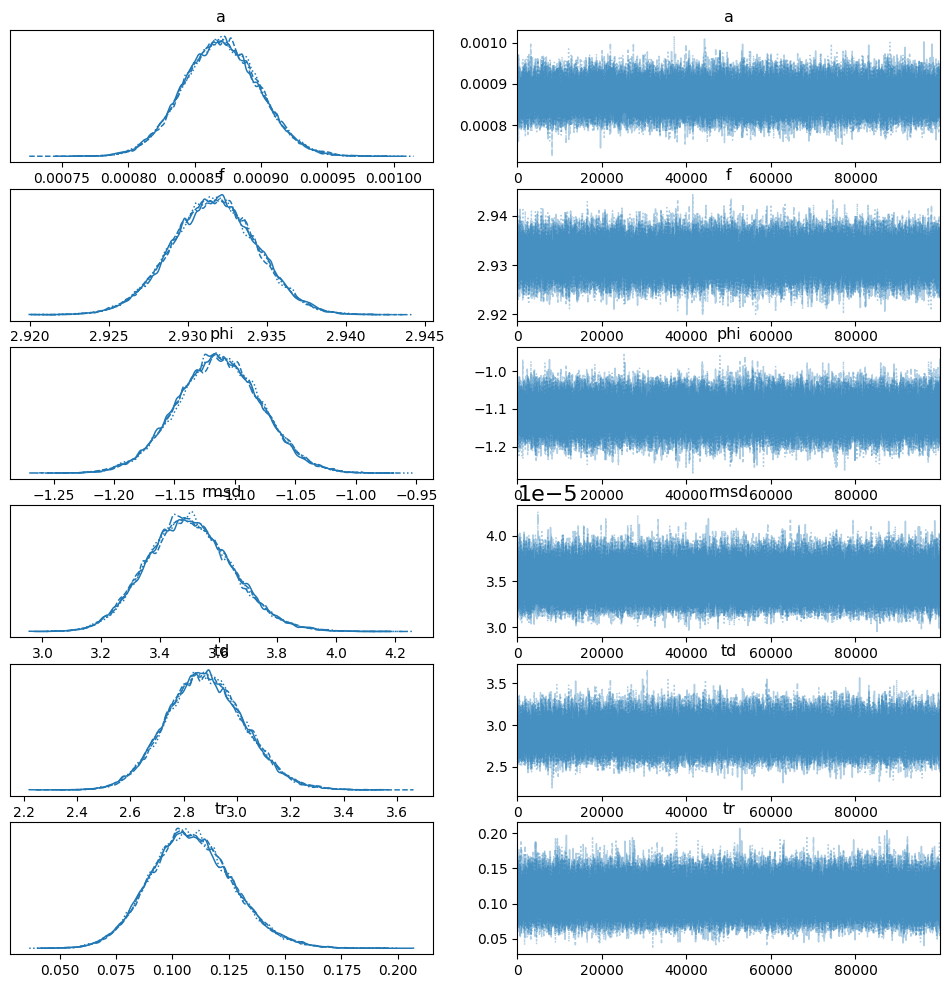

In [28]:
############################################
samplerName = 'Metropolis'
file_BaseName = FilePath + FileBaseName + '-' + samplerName + '-'
# pdf
pdfName = file_BaseName + 'trace.pdf'
# pickle
pklfName = file_BaseName + 'trace.pkl'
#
############################################
run_sampling = True
#
if True == os.path.isfile(pklfName):
  #
  msg = 'Already exists!: ' + pklfName + '\n' + 'Do you run samplings again?'
  #
  if True != YESorNO( msg ):
    run_sampling = False
#
############################################
if run_sampling:
  with pm.Model() as  model:
      #
      a   = pm.Gamma(  'a',   alpha=a_alpha,   beta=a_beta)
      f   = pm.Gamma(  'f',   alpha=f_alpha,   beta=f_beta)
      phi = pm.VonMises('phi',mu=phi_mu,       kappa=phi_kappa)
      tr  = pm.Gamma(  'tr',  alpha=tr_alpha,  beta=tr_beta)
      td  = pm.Gamma(  'td',  alpha=td_alpha,  beta=td_beta)
      #
      rmsd = pm.Uniform('rmsd',lower=RMSD_lower, upper=RMSD_upper )
      #
      y    = pm.Normal('y', mu=DampdOsc(t, a, f, phi, tr, td), sigma=rmsd, observed=y_wn)
      #
      step  = pm.Metropolis()
      #
      traceMetropolis = pm.sample( steps_sampling_, tune=steps_tuning_, step=step, chains=chains_ )
  #
  ############################################
  pm.plot_trace(traceMetropolis)
  plt.savefig( pdfName )
  #
  ############################################
  SaveTrace( pklfName, traceMetropolis )
#

---
NUTSサンプラーによるMCMC
* pymc.NUTS: https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.NUTS.html
* TheNo-U-Turn Sampler:Adaptively Setting Path Lengths in Hamiltonian Monte Carlo: Matthew D. Hoffman, Andrew Gelman, https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf
* レースを保存したpickleファイルが存在する場合、それを利用するか?、再度サンプリングし直すか?を選択する。

Already exists!: drive/My Drive/Colab Notebooks/IntroDDS/Chap02/2PyMC-06DampedOsc/2PyMC-06DampedOsc-NUTS-trace.pkl
Do you run samplings again?
>> 'YES' or 'NO' [Y/N]: Y


Output()

Saving pickle file = drive/My Drive/Colab Notebooks/IntroDDS/Chap02/2PyMC-06DampedOsc/2PyMC-06DampedOsc-NUTS-trace.pkl


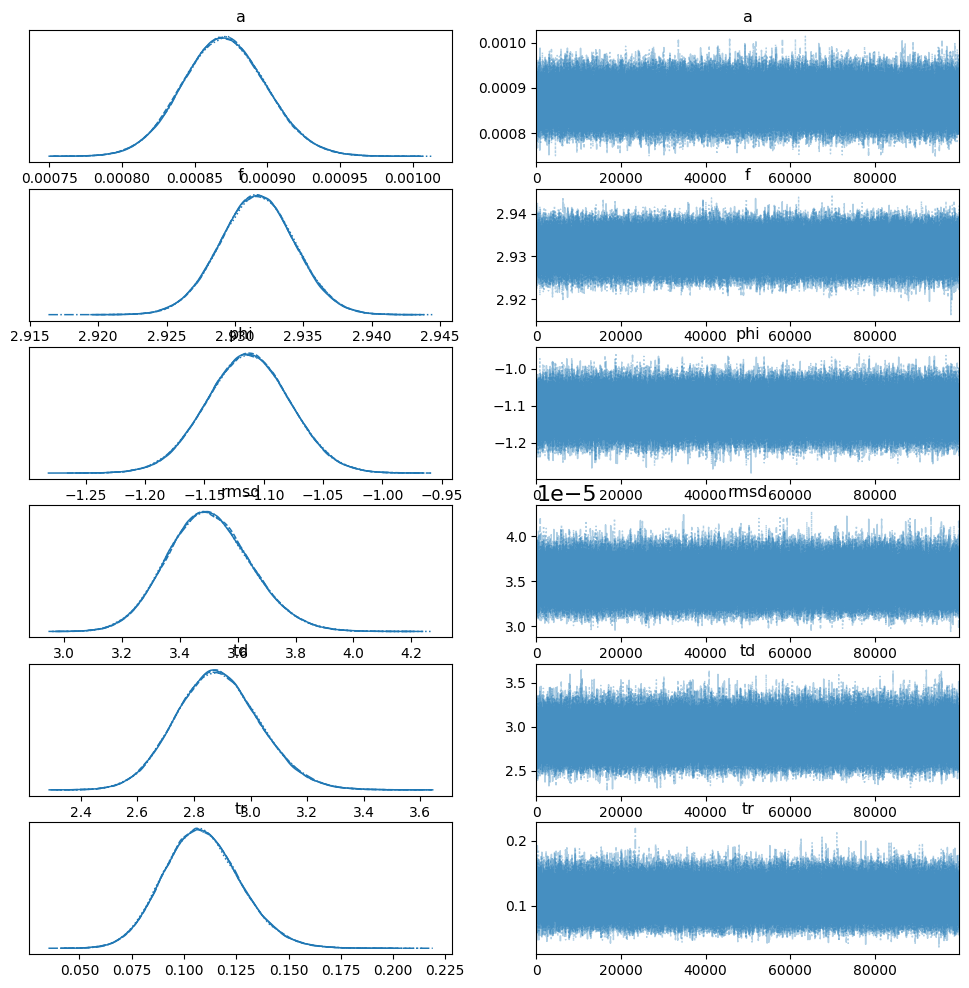

In [29]:
############################################
samplerName = 'NUTS'
file_BaseName = FilePath + FileBaseName + '-' + samplerName + '-'
# pdf
pdfName = file_BaseName + 'trace.pdf'
# pickle
pklfName = file_BaseName + 'trace.pkl'
#
############################################
run_sampling = True
#
if True == os.path.isfile(pklfName):
  #
  msg = 'Already exists!: ' + pklfName + '\n' + 'Do you run samplings again?'
  #
  if True != YESorNO( msg ):
    run_sampling = False
#
############################################
if run_sampling:
  with pm.Model() as  model:
      #
      a   = pm.Gamma(  'a',   alpha=a_alpha,   beta=a_beta)
      f   = pm.Gamma(  'f',   alpha=f_alpha,   beta=f_beta)
      phi = pm.VonMises('phi', mu=phi_mu,      kappa=phi_kappa)
      tr  = pm.Gamma(  'tr',  alpha=tr_alpha,  beta=tr_beta)
      td  = pm.Gamma(  'td',  alpha=td_alpha,  beta=td_beta)
      #
      rmsd = pm.Uniform('rmsd',lower=RMSD_lower, upper=RMSD_upper )
      #
      y    = pm.Normal('y', mu=DampdOsc(t, a, f, phi, tr, td), sigma=rmsd, observed=y_wn)
      #
      traceNUTS = pm.sample( steps_sampling_, tune=steps_tuning_, chains=chains_ )
  #
  ############################################
  pm.plot_trace(traceNUTS)
  #
  pdfName = file_BaseName + 'trace.pdf'
  plt.savefig( pdfName )
  #
  ############################################
  pklfName = file_BaseName + 'trace.pkl'
  SaveTrace( pklfName, traceNUTS )

---
パラメータリスト

In [30]:
############################################
thetas = [
    #[ key, key_label, title,  prior_func, prior_par1, prior_par2
    ['a',   'a',              r'Integrated intensity $a$',        PGamma,    a_alpha, a_beta     ],
    ['f',   'f',              r'Freqnuency $f$ (THz)',            PGamma,    f_alpha, f_beta     ],
    ['phi', '\phi',           r'Initial phase $\phi$ (deg.)',     PVonMises, phi_mu,   phi_kappa ],
    ['tr',  '\\tau_{\\rm r}', r'Rising time $\tau_{\rm r}$ (ps)', PGamma,    tr_alpha, tr_beta   ],
    ['td',  '\\tau_{\\rm d}', r'Decay time $\tau_{\rm d}$ (ps)',  PGamma,    td_alpha, td_beta   ]
]

---
Metropolisサンプラーの結果の診断

In [33]:
############################################
samplerName = 'Metropolis'
file_BaseName = FilePath + FileBaseName + '-' + samplerName + '-'
# pickle
pklfName = file_BaseName + 'trace.pkl'
#
trace = LoadTrace( pklfName )
#
############################################
df_summary, selected_df = Trace_Diagnostics( trace )
#
############################################
# 各事後確率分布等を出力
fig_base_fname = file_BaseName + 'Posterior'
############################################
for theta in thetas:
  #
  ###############
  key        = theta[0]
  key_label  = theta[1]
  title      = theta[2]
  prior_func = theta[3]
  prior_par1 = theta[4]
  prior_par2 = theta[5]
  #
  ###############
  pdfname = fig_base_fname + '-' + key + '.pdf'
  #
  ###############
  Marks = [ ['True', df_summary.at[ key, 'true'], 'black', 'solid'],
            ['MLE',  df_summary.at[ key, 'MLE'],  'red',   'solid'],
            ['MAP',  df_summary.at[ key, 'MAP'],  'blue',  'solid'] ]
  #
  ###############
  fig, mean_, MODE_, bin_vals, bins = grf_PthetaD(
    selected_df[ key ], key_label,
    prior_func, prior_par1, prior_par2,
    theta_marks=Marks,title=title )
  #
  ###############
  fig.savefig( pdfname )
#
############################################
# MAP推定値を用いて再現データを描く
Estimate = 'MAP'
a_hat   = df_summary.at['a',   Estimate]
f_hat   = df_summary.at['f',   Estimate]
phi_hat = df_summary.at['phi', Estimate]
tr_hat  = df_summary.at['tr',  Estimate]
td_hat  = df_summary.at['td',  Estimate]
#
y_reg = DampdOsc(t, a_hat, f_hat, phi_hat, tr_hat, td_hat)
#
############################################
ysets = [ [y_wn,   r'$y(t)$',            'blue', 1.5 ],
          [y_true, r'$y_{\rm true}(t)$', 'red',  1.0 ],
          [y_reg,  r'$y_{\rm '+ Estimate + '}(t)$', 'black', 1.0 ] ]
#
fig = grf_DampedOsc( t, ysets, title=grf_title+' (' + samplerName + ')' )
pdfName = file_BaseName + 'Reg' + Estimate + '.pdf'
fig.savefig( pdfName )
############################################
ysets = [ [y_true, r'$y_{\rm true}(t)$', 'red',  3.0 ],
          [y_reg,  r'$y_{\rm '+ Estimate + '}(t)$', 'black', 1.0 ] ]
#
fig = grf_DampedOsc( t, ysets, title=grf_title+' (' + samplerName + ')' )
pdfName = file_BaseName + 'Reg' + Estimate + '-02.pdf'
fig.savefig( pdfName )
############################################
print( df_summary )

Output hidden; open in https://colab.research.google.com to view.

---
NUTSサンプラーの結果の診断

In [38]:
############################################
samplerName = 'NUTS'
file_BaseName = FilePath + FileBaseName + '-' + samplerName + '-'
# pickle
pklfName = file_BaseName + 'trace.pkl'
#
trace = LoadTrace( pklfName )
#
############################################
df_summary, selected_df = Trace_Diagnostics( trace )
#
############################################
# 各事後確率分布等を出力
fig_base_fname = file_BaseName + 'Posterior'
############################################
for theta in thetas:
  #
  ###############
  key        = theta[0]
  key_label  = theta[1]
  title      = theta[2]
  prior_func = theta[3]
  prior_par1 = theta[4]
  prior_par2 = theta[5]
  #
  ###############
  pdfname = fig_base_fname + '-' + key + '.pdf'
  #
  ###############
  Marks = [ ['True', df_summary.at[ key, 'true'], 'black', 'solid'],
            ['MLE',  df_summary.at[ key, 'MLE'],  'red',   'solid'],
            ['MAP',  df_summary.at[ key, 'MAP'],  'blue',  'solid'] ]
  #
  ###############
  fig, mean_, MODE_, bin_vals, bins = grf_PthetaD(
    selected_df[ key ], key_label,
    prior_func, prior_par1, prior_par2,
    theta_marks=Marks,title=title )
  #
  ###############
  fig.savefig( pdfname )
#
############################################
# MAP推定値を用いて再現データを描く
Estimate = 'MAP'
a_hat   = df_summary.at['a',   Estimate]
f_hat   = df_summary.at['f',   Estimate]
phi_hat = df_summary.at['phi', Estimate]
tr_hat  = df_summary.at['tr',  Estimate]
td_hat  = df_summary.at['td',  Estimate]
#
y_reg = DampdOsc(t, a_hat, f_hat, phi_hat, tr_hat, td_hat)
#
############################################
ysets = [ [y_wn,   r'$y(t)$',            'blue', 1.5 ],
          [y_true, r'$y_{\rm true}(t)$', 'red',  1.0 ],
          [y_reg,  r'$y_{\rm '+ Estimate + '}(t)$', 'black', 1.0 ] ]
#
fig = grf_DampedOsc( t, ysets, title=grf_title+' (' + samplerName + ')' )
pdfName = file_BaseName + 'Reg' + Estimate + '.pdf'
fig.savefig( pdfName )
############################################
ysets = [ [y_true, r'$y_{\rm true}(t)$', 'red',  3.0 ],
          [y_reg,  r'$y_{\rm '+ Estimate + '}(t)$', 'black', 1.0 ] ]
#
fig = grf_DampedOsc( t, ysets, title=grf_title+' (' + samplerName + ')' )
pdfName = file_BaseName + 'Reg' + Estimate + '-02.pdf'
fig.savefig( pdfName )
############################################
print( df_summary )

Output hidden; open in https://colab.research.google.com to view.